In [1]:
%load_ext autoreload
%autoreload 2
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os,sys
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"
sys.path.append('../scripts/')
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jaxley as jx
from jax import jacfwd, jacrev, jvp, jit
from nex.colors import cols as papercols
from network import initialize_RNN as initialise_DMS_RNN


<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Set initial params

g_scaling = 100_000 / 2 / np.pi / 10.0 / 1.0
dt = .025
n_cells = 20
RNN_params = {
    "RNN_seed":3,
    "n_rec":n_cells,
    "n_inh":5,
    "n_out":0,
    "init_gain": 10/g_scaling,
    "out_scale":.1,
    "inp_scale":1,
    "in_conn_prob":.1,
    "out_conn_prob":1,
    "rec_conn_prob":.2,
    "k_minus":1,
    "out_k_minus":.1,
}



In [3]:
# Utility function to get all parameters

def make_trainable(network, state_keys, verbose=True,excludes = ['CaCon_e',"eCa"]):

    network.delete_trainables()
    network.delete_recordings()
    label_comp = ['Apical','Somal','Basal']
    labels = []
    for key in state_keys:
        if verbose:
            print(key)
        # channels
        for i in range(3):
            # check if key exsits and compartment uses this key
            if key in network.cell[i].show() and ~np.isnan(network.cell[i].show()[key].iloc[0]) and key not in excludes:
                network.cell[i].make_trainable(key, verbose=verbose)
                network.cell[i].record(key, verbose=verbose)
                labels.append(label_comp[i] + '_' + key)
        # synapses
        if key in network.IonotropicSynapse("all").show():
            labels.append(key)
            network.IonotropicSynapse("all").make_trainable(key, verbose=verbose)
            network.IonotropicSynapse("all").record(key)

    return labels


In [4]:
network, conn_matrix, input_weights=initialise_DMS_RNN(RNN_params)
network.record(verbose=False)
_, states = jx.integrate(network, return_states=True, t_max=0)
labels = make_trainable(network, states,verbose=False)


3.8333333333333335
69
18
conn probability recurrence: 0.21296296296296297
EIratio:2.5999999999999996
Normaliser: 0.6670371568813486
Spectral radius recurrence: 0.006827378360852144
Added 69 recordings. See `.recordings` for details.


In [5]:
# Get Jacobian functions

param_dict = network.get_parameters()
n_params = network.num_trainable_params

param_keys = [list(param.keys())[0] for param in param_dict]
n_per_key = [len(list(param.values())[0].flatten()) for param in param_dict]
inds = np.cumsum(n_per_key)


def param_dict_to_param_vec(param_dict):
    param_vec = []
    for item in param_dict:
        for key in item:
            param_vec.append(item[key].flatten())
    return jnp.concatenate(param_vec)

def param_vec_to_param_dict(param_vec):
    state_dict = []
    start_idx = 0
    for key in param_keys:
        n = n_per_key[param_keys.index(key)]
        state_dict.append({key: param_vec[start_idx:start_idx+n]})
        start_idx += n
    return state_dict

def one_step(param_vec):
    param_dict = param_vec_to_param_dict(param_vec)
    param_vecn =jx.integrate(network, params=param_dict, t_max=0, delta_t=dt, solver="bwd_euler")[:,-1]
    assert(len(param_vecn)==len(param_vec))
    return param_vecn

def two_step(param_vec):
    param_dict = param_vec_to_param_dict(param_vec)
    param_vecn =jx.integrate(network, params=param_dict, t_max=dt, delta_t=dt, solver="bwd_euler")[:,-1]
    assert(len(param_vecn)==len(param_vec))
    return param_vecn

def ten_step(param_vec):
    param_dict = param_vec_to_param_dict(param_vec)
    param_vecn =jx.integrate(network, params=param_dict, t_max=dt*3, delta_t=dt, solver="bwd_euler")[:,-1]
    assert(len(param_vecn)==len(param_vec))
    return param_vecn

param_vec = param_dict_to_param_vec(network.get_parameters())


In [6]:
# Obtain Jacobians
D1 = jacfwd(one_step)(param_vec)
D2 = jacfwd(two_step)(param_vec)
D10 = jacfwd(ten_step)(param_vec)

In [7]:
# Set zero to nan for plot
D1abs = np.sign(D1)
D1abs[D1abs==0]=np.nan
D2abs = np.sign(D2)
D2abs[D2abs==0]=np.nan
D10abs = np.sign(D10)
D10abs[D10abs==0]=np.nan


In [8]:
# get indices of labels
lab_inds = np.copy(inds)
lab_inds[1:]-=np.int_(np.diff(inds)/2)
lab_inds[0]=inds[0]//2

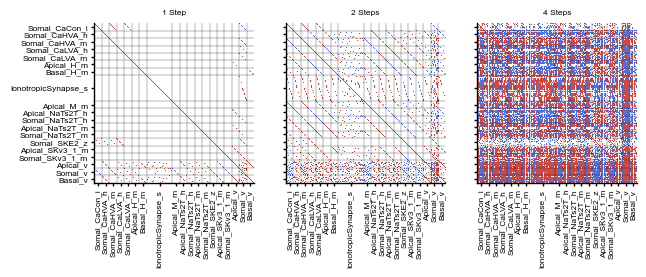

In [10]:
# Make plots
lim =1e-3
lw = .2
lim=1.2
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig,ax = plt.subplots(1,3,figsize=(7,9.7))
    ax[0].imshow(D1abs, vmax = lim,vmin=-lim,cmap = 'coolwarm');
    ax[1].imshow(D2abs, vmax = lim,vmin=-lim,cmap = 'coolwarm');
    ax[2].imshow(D10abs, vmax = lim,vmin=-lim,cmap = 'coolwarm');
    #plt.colorbar(ax=im);
    for a in ax:
        a.set_xticks(lab_inds)
        a.set_xticklabels(labels, rotation=90);
        a.set_yticks(lab_inds)
        a.set_yticklabels([])
        for ind in inds[:-1]:
            a.axvline(ind, color='black',lw=lw)
            a.axhline(ind, color='black',lw=lw)
    ax[0].set_yticklabels(labels);
    ax[0].set_title('1 Step')
    ax[1].set_title('2 Steps')
    ax[2].set_title('4 Steps')
    plt.savefig('../figures/Jacobians.png',dpi=300)
    plt.show()